In [1]:
# Description: Plot the time-mean cross-isobath heat transport (mean and eddy components),
#              and display Table S1 (supplementary materials).
#
#              -Raw mean/eddy HTs along 1000 m isobath.
#              -Cumulative sums of mean/eddy HTs.
#              -Cumulative sums of top, middle and bottom HTs
#              -Segment-integrated onshore HTs
#              -Along-shelf HT convergences
#              -Segment-integrated onshore volume transport.
#
#
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2017

import sys
sys.path.append('../../misc')
sys.path.append('/home/andre/Dropbox/python-modules/pygamman')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from netCDF4 import Dataset, num2date
from datetime import datetime
from cmocean import cm as cmo
from gsw import distance
from pandas import Series, DataFrame, concat
from local_utils import crosscorr, Tdecorr, rsig, angle_isobath
from local_utils import lon360to180, blksum, blkavg, blkavgt, near, near2, seasonal_avg, deseason, rot_vec


def _get_segmsk(x, y, d, seglims, dateline=False):
    xl, xr, yl, yr = seglims
    idxl = near2(x, y, xl, yl, return_index=True)[0]
    idxr = near2(x, y, xr, yr, return_index=True)[0]

    if d[idxl] > d[idxr]:
        idxl, idxr = idxr, idxl

    fseg = np.zeros(x.size)
    #print(idxl,idxr)
    if dateline:
        fseg[:idxl] = 1
        fseg[idxr:] = 1
    else:
        fseg[idxl:idxr] = 1

    return np.bool8(fseg)


plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
##---
plt.close('all')

GET_HT_DIVERGENCE = True
REVERSED_XAXIS = True
isob = 1000
TW2GW = 1e3
# t_afterspinup = datetime(1969, 1, 1) # Cap first 10 years (spin-up).
t_afterspinup = datetime(1959, 1, 1)
# t_afterspinup = datetime(2005, 1, 1)

# Get segment lat/lon limits.
segs_lims = {
'Ross':[165., -150., -79., -68.],
'Byrd':[-150., -130., -79., -68.],
'Amundsen':[-130, -100, -76., -64.],
'Bellingshausen':[-100., -75., -77., -60.],
'S-AP':[-75., -64., -74., -60.],
'N-AP':[-64., -53., -74., -60.],
'Weddell':[-53., -11., -78., -59.],
'W-EA':[-11., 65., -72., -60.],
'C-EA':[65., 100., -72., -60.],
'E-EA':[100., 165., -72., -60.]
}
segnames = segs_lims.keys()

# Load time-varying heat budget file.
head = '../../data_reproduce_figs/'
fnamez = 'hflxmelt_tseries%dm.npz'%isob

fnamez = head + 'large_files/' + fnamez

try:
    dd = np.load(fnamez, encoding='bytes')
except FileNotFoundError:
    print("*ERROR*: File %s not found. Make sure you have downloaded it and placed it in 'data_reproduce_figs/large_files/'."%fnamez)
    sys.exit(1)

for k in dd.keys():
    vars().update({k:dd[k]})

# Get model topography.
ftopo = head + 'POP_topog.nc'
nctopo = Dataset(ftopo).variables
fcap = 501
cm2m = 1e-2
lont, latt, ht = nctopo['TLONG'][:fcap,:], nctopo['TLAT'][:fcap,:], nctopo['HT'][:fcap,:]*1e-2
lont = lon360to180(lont)

# Take only part of the simulation after spin-up.
f_afterspinup = t>=t_afterspinup
UQx = UQx[f_afterspinup,:]
UQxm = UQxm[f_afterspinup,:]
UQxe = UQxe[f_afterspinup,:]
Ux0 = Ux.copy()
Ux = Ux[f_afterspinup,:]
UQxm_100m = UQxm_100m[f_afterspinup,:]
UQxe_100m = UQxe_100m[f_afterspinup,:]
UQxm_100m_700m = UQxm_100m_700m[f_afterspinup,:]
UQxe_100m_700m = UQxe_100m_700m[f_afterspinup,:]
UQxm_700m_1000m = UQxm_700m_1000m[f_afterspinup,:]
UQxe_700m_1000m = UQxe_700m_1000m[f_afterspinup,:]

fnamez_isobs = head + 'isobaths.nc'
ncxm = Dataset(fnamez_isobs)
Im = ncxm["%d m isobath (U-points)"%isob]['i'][:]
Jm = ncxm["%d m isobath (U-points)"%isob]['j'][:]

# Calculate time-averaged mean and eddy components.
# Plot their mean values and their associated variances,
# i.e., standard deviation (in time) for each point (along the isobath).
uqx = UQx.mean(axis=0)
uqxm = UQxm.mean(axis=0)
uqxe = UQxe.mean(axis=0)
uqx_tstd = UQx.std(axis=0)
uqxm_tstd = UQxm.std(axis=0)
uqxe_tstd = UQxe.std(axis=0)
#
uqxmsrf = UQxm_100m.mean(axis=0)
uqxesrf = UQxe_100m.mean(axis=0)
uqxmmid = UQxm_100m_700m.mean(axis=0)
uqxemid = UQxe_100m_700m.mean(axis=0)
uqxmbot = UQxm_700m_1000m.mean(axis=0)
uqxebot = UQxe_700m_1000m.mean(axis=0)

# Time series of total heat transports within each layer.
uqxsrf = uqxmsrf + uqxesrf # 0 - 100 m.
uqxmid = uqxmmid + uqxemid # 100 - 700 m.
uqxbot = uqxmbot + uqxebot # 700 - 1000 m.

# Use longitude as independent coordinate instead of along-isobath distance.
dist = d.copy() # [km].
d = x.copy()

# Volume transport.
ux = Series(Ux.mean(axis=0), index=dist*1e3)
ux = ux.rolling(window=19, win_type='hanning', center=True).mean() # smoothed volume transport.

if REVERSED_XAXIS:
    x = np.flipud(x)
    y = np.flipud(y)
    d = np.flipud(d) # Recall that d is now longitude, so ok to reverse.
    uqxm = np.flipud(uqxm)
    uqxe = np.flipud(uqxe)
    uqx = np.flipud(uqx)
    uqxsrf = np.flipud(uqxsrf)
    uqxmid = np.flipud(uqxmid)
    uqxbot = np.flipud(uqxbot)

# Block-average (in space) the standard deviations.
Lx = 30 # [km], Desired size for each block.
dx = 3.28971284 # [km].
blkstd = int(Lx/dx)
davg, uqxm_tstdavgx, _ = blkavg(d, uqxm_tstd, every=blkstd)
_, uqxe_tstdavgx, _ = blkavg(d, uqxe_tstd, every=blkstd)

# Calculate segment-averaged heat transports.
uqxmseg_avg = dict()
uqxeseg_avg = dict()
uqxseg_avg = dict()

uqxseg_total = dict()
uxseg_total = dict()

didx = np.load(head+'segment_bdry_indices.npz')
idxls, idxrs = didx['idxl'].tolist(), didx['idxr'].tolist()

if REVERSED_XAXIS:
    x2, y2 = np.flipud(x), np.flipud(y)
else:
    x2, y2 = x.copy(), y.copy()

uqxmseg_totaltseries = dict()
uqxeseg_totaltseries = dict()
uqxseg_totaltseries = dict()
uxseg_totaltseries = dict()
uqxmseg_monthly = dict()
uqxeseg_monthly = dict()
uqxseg_monthly = dict()
plt.figure()
for seg in segs_lims.keys():
    idxl = idxls[seg]
    idxr = idxrs[seg]
    fseg = np.int32(np.zeros(x.size))
    if seg=='Ross':
        fseg[:idxl] = 1
        fseg[idxr:] = 1
        aux = dist[fseg]
        Lxseg = dist[idxl] - dist[0] + dist[-1] - dist[idxr] # 180 to 165 plus -150 to -180.
    else:
        fseg[idxl:idxr] = 1
        aux = dist[fseg]
        Lxseg = dist[idxr] - dist[idxl]

    fseg = np.bool8(fseg)
    fseglr = fseg.copy()
    if REVERSED_XAXIS:
        fseg = np.flipud(fseg)

    print(seg, int(Lxseg),'km, ','%d-->%d'%(idxl,idxr))
    plt.plot(x[fseg], y[fseg], marker='.')

    # Time averages of the heat transports averaged along each segment.
    uqxmseg = uqxm[fseg].sum()*TW2GW/Lxseg # Mean, [GW/km].
    uqxeseg = uqxe[fseg].sum()*TW2GW/Lxseg # Eddy, [GW/km].
    uqxseg_tot = uqx[fseg].sum()
    uxseg = Ux[:, fseglr].sum(axis=1)
    uqxmseg_totaltseries.update({seg:UQxm[:, fseglr].sum(axis=1)})#*TW2GW/Lxseg}) # [GW/km]
    uqxeseg_totaltseries.update({seg:UQxe[:, fseglr].sum(axis=1)})#*TW2GW/Lxseg}) # [GW/km]
    uqxseg_totaltseries.update({seg:UQx[:, fseglr].sum(axis=1)})#*TW2GW/Lxseg}) # [GW/km].
    uxseg_totaltseries.update({seg:uxseg}) # [Sv].
    uqxseg = uqxseg_tot*TW2GW/Lxseg        # Total, [GW/km].
    uqxseg_total.update({seg:uqxseg_tot})  # [TW].
    uxseg_total.update({seg:uxseg})        # [Sv].
    #
    uqxmseg_monthly.update({seg:UQxm[:, fseglr].sum(axis=1)})
    uqxeseg_monthly.update({seg:UQxe[:, fseglr].sum(axis=1)})
    uqxseg_monthly.update({seg:UQx[:, fseglr].sum(axis=1)})

    uqxmseg_avg.update({seg:uqxmseg})
    uqxeseg_avg.update({seg:uqxeseg})
    uqxseg_avg.update({seg:uqxseg})

plt.show()
# Integral timescales of Ux, UQxm and UQxe (in months).
nblk = 51 # Each block is 1 year long.
# _ = [print(max(Tdecorr(crosscorr(uxseg_totaltseries[seg],uxseg_totaltseries[seg], nblk)[1])), max(Tdecorr(crosscorr(uqxmseg_totaltseries[seg],uqxmseg_totaltseries[seg], nblk)[1])), max(Tdecorr(crosscorr(uqxeseg_totaltseries[seg],uqxeseg_totaltseries[seg], nblk)[1]))) for seg in segnames]
segnames = list(segs_lims.keys())

# Put it in a pandas DataFrame and print in latex.
col1, col2, col3, col4 = dict(), dict(), dict(), dict()
for seg in segnames:
    a = uxseg_totaltseries[seg] # On-shelf volume transport.
    col1.update({seg:Tdecorr(crosscorr(a, a, nblk)[1]).max()})
    a = uqxmseg_totaltseries[seg] # On-shelf mean heat transport.
    col2.update({seg:Tdecorr(crosscorr(a, a, nblk)[1]).max()})
    a = uqxeseg_totaltseries[seg] # On-shelf eddy heat transport.
    col3.update({seg:Tdecorr(crosscorr(a, a, nblk)[1]).max()})
    a = uqxseg_totaltseries[seg] # On-shelf total heat transport.
    col4.update({seg:Tdecorr(crosscorr(a, a, nblk)[1]).max()})

col1tab1 = DataFrame.from_dict(col1, orient='index', columns=[r'U'])
col2tab1 = DataFrame.from_dict(col2, orient='index', columns=[r'UQxm'])
col3tab1 = DataFrame.from_dict(col3, orient='index', columns=[r'UQxe'])
col4tab1 = DataFrame.from_dict(col4, orient='index', columns=[r'UQx'])
table1 = concat((col1tab1,col2tab1,col3tab1,col4tab1), axis=1)
table1_latex = table1.to_latex(float_format='%1.2f').replace('\\\\','\\')

# Maximum absolute value of correlation and lag at which it happens.
col1, col2, col3, col4 = dict(), dict(), dict(), dict()
for seg in segnames:
    a = uxseg_totaltseries[seg] # On-shelf volume transport.
    b = uqxmseg_totaltseries[seg] # On-shelf mean heat transport.
    c = crosscorr(a, b, nblk)[1]
    idm = np.nanargmax(np.abs(c))
    col1.update({seg:(c[idm],idm)})
    b = uqxeseg_totaltseries[seg] # On-shelf eddy heat transport.
    c = crosscorr(a, b, nblk)[1]
    idm = np.nanargmax(np.abs(c))
    col2.update({seg:(c[idm],idm)})
    b = uqxseg_totaltseries[seg] # On-shelf total heat transport.
    c = crosscorr(a, b, nblk)[1]
    idm = np.nanargmax(np.abs(c))
    col3.update({seg:(c[idm],idm)})
    # Mean-eddy heat transport correlation.
    a = uqxmseg_totaltseries[seg]
    b = uqxeseg_totaltseries[seg]
    c = crosscorr(a, b, nblk)[1]
    idm = np.nanargmax(np.abs(c))
    col4.update({seg:(c[idm],idm)})

col1tab2 = DataFrame.from_dict(col1, orient='index')
col2tab2 = DataFrame.from_dict(col2, orient='index')
col3tab2 = DataFrame.from_dict(col3, orient='index')
col4tab2 = DataFrame.from_dict(col4, orient='index')
table_S1 = concat((col1tab2,col2tab2,col3tab2,col4tab2), axis=1)
table_S1_latex = table_S1.to_latex(float_format='%1.3f').replace('\\\\','\\')

# Numer of Effective DoF for each cross-correlation and associated minimum r.
# Take the integral timescale of the slower of the two variables for each pair.
nseries = 612/nblk # Number of months on each independent time series.
edof_UUQxm = nseries/concat((col1tab1, col2tab1), axis=1).max(axis='columns')
edof_UUQxe = nseries/concat((col1tab1, col3tab1), axis=1).max(axis='columns')
edof_UUQx = nseries/concat((col1tab1, col4tab1), axis=1).max(axis='columns')
edof_UQxmUQxe = nseries/concat((col2tab1, col3tab1), axis=1).max(axis='columns')
alpha = 0.95
print('')
print("=== U-UQxm ===")
_ = [print('Minimum significant r for %1.3f EDoF at %d %%: %1.3f'%(edof, alpha*100, rsig(edof, alpha=alpha))) for edof in edof_UUQxm]
print("=== U-UQxe ===")
_ = [print('Minimum significant r for %1.3f EDoF at %d %%: %1.3f'%(edof, alpha*100, rsig(edof, alpha=alpha))) for edof in edof_UUQxe]
print("=== U-UQxt ===")
_ = [print('Minimum significant r for %1.3f EDoF at %d %%: %1.3f'%(edof, alpha*100, rsig(edof, alpha=alpha))) for edof in edof_UUQx]
print("=== UQxm-UQxe ===")
_ = [print('Minimum significant r for %1.3f EDoF at %d %%: %1.3f'%(edof, alpha*100, rsig(edof, alpha=alpha))) for edof in edof_UQxmUQxe]

df1 = np.abs(col1tab2[0])>=rsig(edof_UUQxm, alpha=alpha)
df2 = np.abs(col2tab2[0])>=rsig(edof_UUQxe, alpha=alpha)
df3 = np.abs(col3tab2[0])>=rsig(edof_UUQx, alpha=alpha)
df4 = np.abs(col4tab2[0])>=rsig(edof_UQxmUQxe, alpha=alpha)
issig_table_S1 = concat((df1, df2, df3, df4), axis=1)

# lon, lat, ht must start at -180 to plot contour.
fcut = np.where(np.abs(np.diff(lont[0,:]))>10)[0][0] + 1
lont = np.hstack((lont[:,fcut:], lont[:,:fcut]))
latt = np.hstack((latt[:,fcut:], latt[:,:fcut]))
ht = np.hstack((ht[:,fcut:], ht[:,:fcut]))

NameError: name 'ssss' is not defined

In [4]:
uqxm.sum(), uqxe.sum(), uqx.sum()

(4.553422437517408, 15.09881663252007, 19.652239070037442)

In [2]:
# Display Table S1 (supplemental materials).
table_S1.head(n=10)

,0,1,0,1,0,1,0,1
Ross,0.813747,10,-0.947668,10,0.347819,4,-0.752481,10
Byrd,0.874408,10,-0.997440,10,0.373865,10,-0.867379,10
Amundsen,0.767710,10,-0.998246,10,-0.391617,10,-0.758370,10
Bellingshausen,0.795485,10,-0.995015,10,0.418300,10,-0.773784,10
S-AP,0.752589,10,-0.991301,10,-0.418367,10,-0.730592,10
N-AP,0.617345,10,-0.998597,10,-0.798786,10,-0.618032,10
Weddell,0.745902,10,-0.992179,10,-0.879257,10,-0.742818,10
W-EA,-0.450980,20,-0.958306,10,0.523437,18,-0.257581,10
C-EA,0.740218,10,-0.991837,10,-0.613782,13,-0.716760,10
E-EA,0.749845,13,-0.978652,10,0.841594,15,-0.768746,7


In [3]:
# Display array with 'True' where the corresponding entry in Table S1 (supplemental materials)
# is statistically significant at the 95 % confidence level.
issig_table_S1.head(n=10)

,0,1,2,3
Ross,True,True,False,True
Byrd,True,True,False,True
Amundsen,True,True,False,True
Bellingshausen,True,True,False,True
S-AP,True,True,False,True
N-AP,True,True,True,True
Weddell,True,True,True,True
W-EA,True,True,True,False
C-EA,True,True,True,True
E-EA,True,True,True,True


In [4]:
# Estimate segment-averaged transports from Stewart et al. (2018)'s results.
stewart_etal2018_transports_MWpermeter_at1000m_isob = {'EA':2, 'Amery':2.5, 'Maud':0.1, 'Ross':5, 'Amundsen':2, 'Bellingshausen':1.8, 'WAP':-2.4, 'Weddell':1} # [MW/m or GW/km].
stewart_etal2018_Lsegs = {'EA':2690, 'Amery':1556, 'Maud':1986, 'Ross':2346, 'Amundsen':1726, 'Bellingshausen':955, 'WAP':1041, 'Weddell':2792} # [km].

phi_total_segs_stewart_etal2018 = {}
for seg in stewart_etal2018_Lsegs.keys():
    Phi_Lavg = stewart_etal2018_transports_MWpermeter_at1000m_isob[seg]
    L = stewart_etal2018_Lsegs[seg]
    Phi = Phi_Lavg*L*1e-3 # [TW].
    phi_total_segs_stewart_etal2018.update({seg:Phi})
print(phi_total_segs_stewart_etal2018)

# In [30]: phi_total_segs_stewart_etal2018
# Out[30]:
# {'Amery': 3.89,                 ~C-EA
#  'Amundsen': 3.452,             ~Amundsen + Byrd (1.6 TW)
#  'Bellingshausen': 1.719,       ~Bellingshausen
#  'EA': 5.38,                    ~E-EA
#  'Maud': 0.19860000000000003,   ~W-EA
#  'Ross': 11.73,                 ~Ross + a piece of E-EA
#  'WAP': -2.4984,                ~S-AP + N-AP
#  'Weddell': 2.7920000000000003} ~Weddell.

F = 0
for Fi in phi_total_segs_stewart_etal2018.values():
    F+=Fi

print('Net circumpolar transport (Stewart et al. (2018): %.2f TW'%F)
# Stewart et al. (2018)'s Sep/2011-Oct2012 average: 26.66 TW
# Dinniman et al. (2015)'s 2005-2009 average: ~50 TW
# This study's 2005-2009 average: ~20.3 TW

{'EA': 5.38, 'Amery': 3.89, 'Maud': 0.19860000000000003, 'Ross': 11.73, 'Amundsen': 3.452, 'Bellingshausen': 1.719, 'WAP': -2.4984, 'Weddell': 2.7920000000000003}
Net circumpolar transport (Stewart et al. (2018): 26.66 TW


In [5]:
#################################################################
# Choose bounding longitudes for psimean and psieddy calculation.
#################################################################
segbrys_psi = {
'weddell_C':(-50.0, -25.0),  # Central Weddell
'Maud':(20, 60),             # Maud Coast, part of W-EA where there is that weird cancellation between different layers (Fig 3c).
'Amery_wE-EA':(55, 120),     # Combined Amery- and west part of E-EA. Similar to Stewart et al. (2018)'s Fig 3.
'E-EA_E':(122.7, 153.7),     # East E-EA peak UQxe area.
'Ross_W':(165.0, 180.0),     # W Ross, strong onshore UQxe and strong offshore UQxm.
'E_Ross':(-173, -153),       # E Ross (~the gray stripe).
'Byrd_W':(-150, -135),       # West Byrd Coast (a localized cancellation).
'Amundsen_E':(-115.0, -102.34),  # E Amundsen (gray stripe).
'Bellingshausen_E':(-86.0, -75.0),     # E Bellingshausen (another gray stripe).
}
npzname = head + 'segment_bdry_lonlatgrid_indices_for_streamfunction_calculations.npz'
np.savez(npzname, segbrys_psi=segbrys_psi)

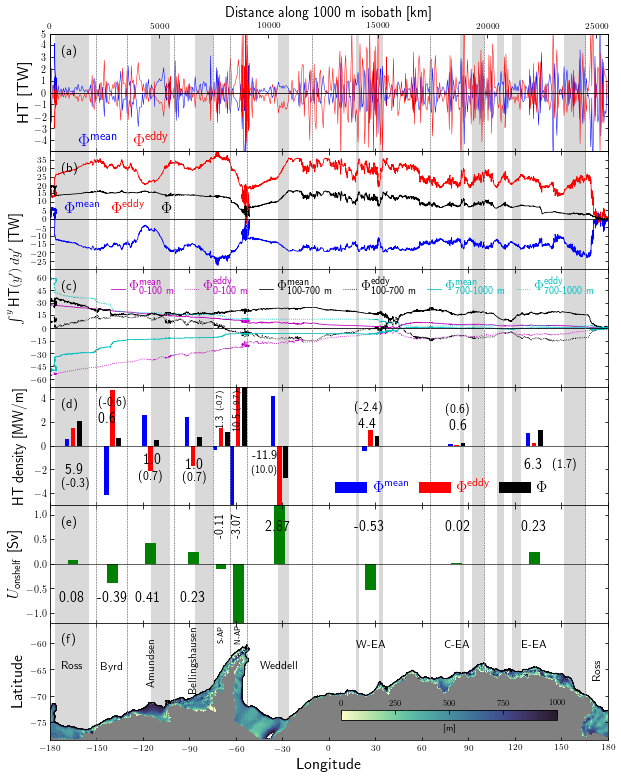

In [6]:
############
# Figure 3 #
############

figsize = (10, 13) # (8, 10)
fig, ax = plt.subplots(nrows=6, figsize=figsize, sharex=True)

ax[2].plot(d, np.cumsum(uqxmsrf), 'm', linestyle='-', linewidth=0.8, alpha=1.0, label=r'$\Phi^\text{mean}_\text{0-100 m}$')
ax[2].plot(d, np.cumsum(uqxesrf), 'm', linestyle=':', linewidth=0.8, alpha=1.0, label=r'$\Phi^\text{eddy}_\text{0-100 m}$')
ax[2].plot(d, np.cumsum(uqxmmid), 'k', linestyle='-', linewidth=0.8, alpha=1.0, label=r'$\Phi^\text{mean}_\text{100-700 m}$')
ax[2].plot(d, np.cumsum(uqxemid), 'k', linestyle=':', linewidth=0.8, alpha=1.0, label=r'$\Phi^\text{eddy}_\text{100-700 m}$')
ax[2].plot(d, np.cumsum(uqxmbot), 'c', linestyle='-', linewidth=0.8, alpha=1.0, label=r'$\Phi^\text{mean}_\text{700-1000 m}$')
ax[2].plot(d, np.cumsum(uqxebot), 'c', linestyle=':', linewidth=0.8, alpha=1.0, label=r'$\Phi^\text{eddy}_\text{700-1000 m}$')

ax[2].set_ylabel(r'$\int^y \text{HT}(y^\prime) \, dy^\prime$ [TW]', fontsize=14, fontweight='black', labelpad=6, y=1)

ax[1].plot(d, np.cumsum(uqxm), 'b', linewidth=0.80)
ax[1].plot(d, np.cumsum(uqxe), 'r', linewidth=0.80)
ax[1].plot(d, np.cumsum(uqx), 'k', linewidth=0.80)

ax[0].set_ylabel(r'HT [TW]', fontsize=16, fontweight='black', labelpad=2)

uqeddyfac = 1
# Block-average to smooth.
Lx = 30 # [km], Desired size for each block.
dx = 3.28971284 # [km].
blks = int(Lx/dx)
_, uqxm_sumx = blksum(d, uqxm, every=blks)
dsum, uqxe_sumx = blksum(d, uqxe, every=blks)
uqx_sumx = uqxm_sumx + uqxe_sumx
ax[0].plot(dsum, uqxm_sumx, 'b', linewidth=0.5)
ax[0].plot(dsum, uqxe_sumx*uqeddyfac, 'r', linewidth=0.5)

ax0dummy = ax[0].twiny()
ax0dummy.xaxis.set_tick_params(labelsize=9, labelbottom=False, labeltop=True, pad=3)
ax0dummy.grid(False)
ax0dummy.plot(dist, dist*0, linestyle='none')
ax0dummy.set_xlim((0, dist.max()))

ax[2].axhline(y=0, color='k', linewidth=1.0, linestyle='-', alpha=0.8)
ax[1].axhline(y=0, color='k', linewidth=1.0, linestyle='-', alpha=0.8)
ax[0].axhline(y=0, color='k', linewidth=1.0, linestyle='-', alpha=0.8)

# Mask deeper than 1000.
htdeep = 1000
fmsk = head + 'volmsk%dm.npz'%htdeep
mskdeep = ~np.bool8(np.load(fmsk)['volmsk'])
mskdeep = np.hstack((mskdeep[:,fcut:], mskdeep[:,:fcut]))
ht = np.ma.masked_where(mskdeep, ht)
ht[ht==0] = -1

# Plot model bottom topography.
dmin, dmax = 0, 1000
dtk = 250
cs = ax[5].pcolor(lont, latt, ht, cmap=cmo.deep, vmin=0, vmax=htdeep, zorder=-9)
# Mask land.
cs.cmap.set_under(color=[0.5]*3)
cs.cmap.set_over(alpha=0)
cbaxes = fig.add_axes([0.53, 0.147, 0.30, 0.01])
cb = plt.colorbar(mappable=cs, cax=cbaxes, orientation='horizontal')#, extend='max')
cb.set_ticks(np.arange(dmin, dmax+dtk, dtk))
cb.ax.xaxis.set_tick_params(labelsize=8, pad=2)
cb.ax.xaxis.set_ticks_position('top')
cb.set_label(r'[m]', fontsize=9, fontweight='normal')

ax[2].set_ylim(-70, 70)
ax[2].set_yticks([-60, -45, -30, -15, 0, 15, 30, 45, 60])
ax[1].set_yticks(np.arange(-25, 40, 5))
ax[1].set_ylim(-30, 40)
ax[0].set_ylim(-5, 5)
ax[3].set_ylim(-5, 5)
ax[4].set_ylim(-1.2, 1.2)
ax[0].set_yticks(np.arange(-4, 6))
ax[3].set_yticks([-4, -2, 0, 2, 4])
ax[4].set_yticks([-1, -0.5, 0, 0.5, 1])
ax[5].set_ylim(-80, -55)#-60)
ax[2].xaxis.set_tick_params(labelsize=9)
ax[2].yaxis.set_tick_params(labelsize=9)
ax[1].yaxis.set_tick_params(labelsize=9)
ax[0].xaxis.set_tick_params(labelsize=10)
ax[0].yaxis.set_tick_params(labelsize=10)
ax[3].yaxis.set_tick_params(labelsize=10)
ax[4].yaxis.set_tick_params(labelsize=10)
ax[5].xaxis.set_tick_params(labelsize=9)
ax[5].yaxis.set_tick_params(labelsize=9)

# Plot model 1000 m isobath.
ax[5].plot(x, y, 'k', linewidth=0.8)

dlontick = 30
lon_ticks = np.arange(-180, 180+dlontick, dlontick)
ax[5].axis('tight')
ax[5].set_xticks(lon_ticks)
ax0dummy.set_xlabel(r"Distance along 1000 m isobath [km]", fontsize=14, fontweight='black')
ax[5].set_xlabel(r"Longitude", fontsize=16, fontweight='black')
ax[5].set_ylabel(r"Latitude", fontsize=16, fontweight='black', labelpad=5)

# Vertical lines marking segments.
kwvl = dict(color='gray', linestyle='--', linewidth=0.5)
for seg in segs_lims.keys():
    lol, lor = segs_lims[seg][:2]
    ax[2].axvline(x=lol, **kwvl)
    ax[2].axvline(x=lor, **kwvl)
    ax[1].axvline(x=lol, **kwvl)
    ax[1].axvline(x=lor, **kwvl)
    ax[0].axvline(x=lol, **kwvl)
    ax[0].axvline(x=lor, **kwvl)
    ax[3].axvline(x=lol, **kwvl)
    ax[3].axvline(x=lor, **kwvl)
    ax[4].axvline(x=lol, **kwvl)
    ax[4].axvline(x=lor, **kwvl)
    ax[5].axvline(x=lol, **kwvl)
    ax[5].axvline(x=lor, **kwvl)

# Names of segments and longitudes to plot the names.
seg_txts = {r'E-EA':132.5, r'C-EA':82.5, r'Weddell':-32.0, r'Bellingshausen':-87.5, r'W-EA':27.0, r'Ross':-165.0, r'Byrd':-139.5, r'Amundsen':-115.0, r'S-AP':-69.5, r'N-AP':-58.5}

# Plot segment-averaged heat transports.
dlo = 4
lonpltsc = dict()
lonpltsl = dict()
lonpltsr = dict()
uqxmseg_avgs = dict()
uqxeseg_avgs = dict()
uqxseg_avgs = dict()
for seg in segs_lims.keys():
    lonplti = seg_txts[seg]
    lonpltsc.update({seg:(lonplti)})
    lonpltsl.update({seg:(lonplti-dlo)})
    lonpltsr.update({seg:(lonplti+dlo)})
    uqxmseg_avgs.update({seg:uqxmseg_avg[seg]})
    uqxeseg_avgs.update({seg:uqxeseg_avg[seg]})
    uqxseg_avgs.update({seg:uqxseg_avg[seg]})

uqsegtxt = {'Ross':(-170, -2.0120672139699529),
'Byrd':(-149, 2.2711759699074783),
'Amundsen':(-119, -1.226805963592426),
'Bellingshausen':(-92.322580645161281, -1.5837428955822119),
'S-AP':(-70.258064516129025, 2.0),
'N-AP':(-59.225806451612897, 2.0),
'Weddell':(-33.096774193548384, -0.79848164520468146),
'W-EA':(24.387096774193594, 1.8428516515197337),
'C-EA':(83, 1.7000768787238201),
'E-EA':(131.80645161290323, -1.5837428955822119)}

uqsegtxt2 = {'Ross':(-173, -3.2),
'Byrd':(-149, 3.7),
'Amundsen':(-123, -2.6),
'Bellingshausen':(-95, -2.7),
'S-AP':(-70.258064516129025, 3.85),
'N-AP':(-59.225806451612897, 3.85),
'Weddell':(-33.096774193548384, -2.1),
'W-EA':(25.5, 3.3),
'C-EA':(83, 3.1),
'E-EA':(152, -1.5837428955822119)}

uqsegtxt3 = {'Ross':(-166, 0.75),
'Byrd':(-140, 0.75),
'Amundsen':(-117, 0.75),
'Bellingshausen':(-88, 0.75),
'S-AP':(-70.258064516129025, 0.75),
'N-AP':(-59.225806451612897, 0.75),
'Weddell':(-33.096774193548384, 0.75),
'W-EA':(25.5, 0.75),
'C-EA':(83, 0.75),
'E-EA':(132, 0.75)}

# Get along-shelf heat transport divergences.
if GET_HT_DIVERGENCE:
    #=======================================================
    fnamez = head+'hflxmelt_alongshelf_xwbry_tseries%dm.npz'%isob
    dashf = np.load(fnamez, encoding='bytes')
    segs = [b'N-AP', b'E-EA', b'Weddell', b'W-EA', b'S-AP', b'Byrd', b'Amundsen', b'Ross', b'C-EA', b'Bellingshausen']
    tt = dashf['t']
    UQx_timemean_alongshelf_convergence = dict()
    for seg in segs_lims.keys():
        uqxconv_ashf = -dashf['UQxdiv_ashf'].flatten()[0][seg].mean()  # Note sign change. Using convergence to compare
        UQx_timemean_alongshelf_convergence.update({seg:uqxconv_ashf}) # with the cross-isobath heat transport (positive onshore, i.e., also convergent).
    #=======================================================

    nseg=1
    barw = 3
    for seg in segs_lims.keys():
        ax[3].bar(lonpltsl[seg], uqxmseg_avgs[seg], barw, linewidth=0, color='b', label=r'$\Phi^\text{mean}$')
        ax[3].bar(lonpltsc[seg], uqxeseg_avgs[seg], barw, linewidth=0, color='r', label=r'$\Phi^\text{eddy}$')
        ax[3].bar(lonpltsr[seg], uqxseg_avgs[seg], barw, linewidth=0, color='k', label=r'$\Phi$')
        #
        # Plot total heat transport in segment as text.
        if seg in ['Ross', 'Byrd', 'Amundsen', 'Bellingshausen']:
            ha = 'left'
        elif seg=='Weddell':
            ha = 'right'
        else:
            ha = 'center'
        xtt, ytt = uqsegtxt[seg]
        xtt2, ytt2 = uqsegtxt2[seg]
        if seg in ['S-AP', 'N-AP']:
            fontsize = 10.5
            rotation = 90
        elif seg=='Weddell':
            fontsize = 12.5
            rotation = 0
        else:
            fontsize = 14
            rotation = 0
        ax[3].text(xtt, ytt, round(uqxseg_total[seg], 1), color='k', fontsize=fontsize, fontweight='black', ha=ha, va='center', rotation=rotation)
        txt2 = '(' + str(round(UQx_timemean_alongshelf_convergence[seg], 1)) + ')'
        ax[3].text(xtt2, ytt2, txt2, color='k', fontsize=(fontsize-2), fontweight='black', ha=ha, va='center', rotation=rotation)
        if nseg==1:
            ax[3].axhline(y=0, color='k', linewidth=0.6, linestyle='-')
            legh = ax[3].legend(loc=(0.5, 0.02), frameon=False, fancybox=False, framealpha=0, fontsize=16, handletextpad=0.35, ncol=3, columnspacing=0.6)
            for legobj, legtxt in zip(legh.legendHandles, legh.get_texts()):
                legtxt.set_color(legobj.get_facecolor())
        nseg+=1

    #np.savez(head+'hflxmelt_onshelf_tseries.npz', t=t, uqxseg_onshore=uqxseg_monthly, uqxmseg_onshore=uqxmseg_monthly, uqxeseg_onshore=uqxeseg_monthly, uxseg_onshore=uxseg_total)

    f_ashf_div = head+'hflxmelt_alongshelf_xwbry_tseries%dm.npz'%isob
    dd_ashf = np.load(f_ashf_div, encoding='bytes')
    UQxdiv_ashf = dd_ashf['UQxdiv_ashf'].flatten()[0]
    Ux_ashf = dd_ashf['Ux'].flatten()[0]
    Uxdiv_ashf = dd_ashf['Uxdiv_ashf'].flatten()[0]

    segnames = ['C-EA', 'W-EA', 'Ross', 'Byrd', 'S-AP', 'Weddell', 'Amundsen', 'N-AP', 'E-EA', 'Bellingshausen']
    bsegnames = [b'C-EA', b'W-EA', b'Ross', b'Byrd', b'S-AP', b'Weddell', b'Amundsen', b'N-AP', b'E-EA', b'Bellingshausen']
    uqxseg_total_conv = dict()
    uxseg_total_conv = dict()
    uxseg_ashf_conv = dict()
    uqxseg_ashf_conv = dict()
    for segn in segnames:
        uqtotconv = uqxseg_total[segn] - UQxdiv_ashf[segn]
        utotconv = uxseg_total[segn] - Uxdiv_ashf[segn]
        uqxseg_total_conv.update({segn:uqtotconv})
        uxseg_total_conv.update({segn:utotconv})
        uxseg_ashf_conv.update({segn:-Uxdiv_ashf[segn]}) # Just switch sign convention (positive = along-shelf CONVERGENCE).
        uqxseg_ashf_conv.update({segn:-UQxdiv_ashf[segn]})

    #np.savez(head+'htadv_tseries.npz', t=t, uqx_alongshelf_convergence=uqxseg_ashf_conv, uqx_onshore=uqxseg_monthly, uqxm_onshore=uqxmseg_monthly, uqxe_onshore=uqxeseg_monthly)

nseg=1
barw = 7
for seg in segs_lims.keys(): # Volume transport integrated over each segment.
    xtt3, ytt3 = uqsegtxt3[seg]
    uxseg_onsh = uxseg_total[seg].mean()
    txt3 = '%1.2f'%uxseg_onsh # Onshore transport only.
    if seg in ['S-AP', 'N-AP']:
        ax[4].text(xtt3, ytt3, txt3, fontsize=12, fontweight='black', ha='center', va='center', rotation=90)
    elif seg in ['Ross', 'Byrd', 'Amundsen', 'Bellingshausen']:
        ax[4].text(xtt3, -0.7, txt3, fontsize=14, fontweight='black', ha='center', va='center', rotation=0)
    else:
        ax[4].text(xtt3, ytt3, txt3, fontsize=14, fontweight='black', ha='center', va='center', rotation=0)

    if nseg==1:
        ax[4].bar(lonpltsc[seg], uxseg_onsh, barw, linewidth=0, color='g', label=r'$U_\text{onshelf}$')
    else:
        ax[4].bar(lonpltsc[seg], uxseg_onsh, barw, linewidth=0, color='g')
    nseg+=1

ax[4].axhline(y=0, color='k', linewidth=0.6, linestyle='-')
ax[3].set_ylabel(r'HT density [MW/m]', fontsize=14, fontweight='black', labelpad=7)
ax[4].set_ylabel(r'$U_\text{onshelf}$ [Sv]', fontsize=15, fontweight='black', labelpad=2)

for txt, xtxt in seg_txts.items():
    if txt=='Amundsen' or 'EA' in txt:
        yt = -61
    elif txt=='S-AP' or txt=='N-AP':
        yt = -57.8
    elif txt=='Bellingshausen':
        yt = -58.5
    else:
        yt = -65.0

    if 'EA' in txt or txt=='Weddell' or txt=='Ross' or txt=='Byrd':
        rotation = 0
    else:
        rotation = 90

    if txt=='S-AP' or txt=='N-AP':
        fontsize = 7.5
    elif txt=='Amundsen' or txt=='Bellingshausen':
        fontsize=11
    else:
        fontsize = 11.5

    ax[5].text(xtxt, yt, txt, fontsize=fontsize, fontweight='demibold', rotation=rotation, transform=ax[5].transData, ha='center')
    if txt=='Ross':
        ax[5].text(173, yt, txt, fontsize=fontsize, fontweight='demibold', rotation=90, transform=ax[5].transData, ha='center')

tt3 = 'Time- and segment-averaged $\Phi$'
xletter, yletter = 0.022, 0.825
xtt, ytt = 0.065, 0.825
ax[0].text(xletter, yletter, r'(a)', fontsize=13, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(xletter, yletter, r'(b)', fontsize=13, fontweight='bold', transform=ax[1].transAxes)
ax[2].text(xletter, yletter, r'(c)', fontsize=13, fontweight='bold', transform=ax[2].transAxes)
ax[3].text(xletter, yletter, r'(d)', fontsize=13, fontweight='bold', transform=ax[3].transAxes)
ax[4].text(xletter, yletter, r'(e)', fontsize=13, fontweight='bold', transform=ax[4].transAxes)
ax[5].text(xletter, yletter, r'(f)', fontsize=13, fontweight='bold', transform=ax[5].transAxes)

fig.subplots_adjust(hspace=0.0)#0.04)#0.025)
legh = ax[2].legend(loc=(0.10, 0.72), frameon=False, fancybox=False, framealpha=0, fontsize=14, handlelength=1.0, handletextpad=0.30, ncol=6, columnspacing=0.8, markerscale=10)

for legobj, legtxt in zip(legh.legendHandles, legh.get_texts()):
    legtxt.set_color(legobj.get_color())

ax[2].grid(False)
ax[1].grid(False)
ax[0].grid(False)
ax[3].grid(False)
ax[4].grid(False)
ax[5].grid(False)
ax[5].set_xlim((-180, 180))

# Add shadings marking segments of O(100-1000 km) onshore HT.
darkgray = [0.85]*3
rects = [(-115.00, -102.34), (-86.00, -75.00), (-32.90, -25.645), (17.419, 19.742),
         (32.18, 35.08), (84.68, 87.097), (108.63, 112.99), (118.31, 124.12), (151.45, 166.21),
         (-176.52, -154.45), (92.32, 100.45)]
for rect in rects:
    for a in [0, 1, 2, 3, 4, 5]:
        if a==5:
            zorder = -10
        else:
            zorder = -9999
        ax[a].axvspan(*rect, facecolor=darkgray, alpha=1, zorder=zorder)

kwtxt0 = dict(fontsize=18, fontweight='black', transform=ax[0].transAxes)
ax[0].text(0.05, 0.05, r'$\Phi^\text{mean}$', color='b', **kwtxt0)
ax[0].text(0.15, 0.05, r'$\Phi^\text{eddy}$', color='r', **kwtxt0)
kwtxt1 = dict(fontsize=16, fontweight='black', transform=ax[1].transAxes)
ax[1].text(0.025, 0.47, r'$\Phi^\text{mean}$', color='b', **kwtxt1)
ax[1].text(0.110, 0.47, r'$\Phi^\text{eddy}$', color='r', **kwtxt1)
ax[1].text(0.200, 0.47, r'$\Phi$', color='k', **kwtxt1)

_ = [axn.set_facecolor('w') for axn in ax.tolist()]
plt.draw()
plt.show()

figname = 'fig_circphi_tmean.png'
fig.savefig(figname, bbox_inches='tight', pad_inches=0.001, dpi=125)
plt.show()

In [7]:
uqxseg_total

{'Ross': 5.946712594741191,
 'Byrd': 0.5844018306918203,
 'Amundsen': 0.9569699593246848,
 'Bellingshausen': 1.030434740356235,
 'S-AP': 1.2574057794268876,
 'N-AP': 10.50758349841415,
 'Weddell': -11.884949698154362,
 'W-EA': 4.356129709014348,
 'C-EA': 0.5590037382516635,
 'E-EA': 6.338546917970823}